Here we'll demonstrate the main features of FutureUnknown  

First we'll load an example time series. For this we'll use data from [FRED](fred.stlouisfed.org), specifically the monthly average price of potato chips in the us. We'll download this directly using the FRED API. This requires an API key, which is loaded here from a .env file locally. This can't be shared, but you could use your own key as the api_key argument of the get_fred_observations() function.

In [1]:
import subprocess
import os
import sys
import json
from dotenv import load_dotenv
import pandas as pd

srcpath = os.path.realpath("../src/")
if srcpath not in sys.path:
    sys.path.append(srcpath)

load_dotenv("../.env")


def get_fred_observations(series_id, api_key, file_type="json"):
    completed_process = subprocess.run(
        [
            "curl",
            f"https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type={file_type}",
        ],
        capture_output=True,
    )
    if completed_process.returncode == 0:
        observations = completed_process.stdout.decode("utf-8")
        observations = json.loads(observations)
        data = []
        for observation in observations["observations"]:
            d = {}
            d["date"] = pd.to_datetime(observation["date"])
            d[series_id] = float(observation["value"])
            data.append(d)
        data = pd.DataFrame(data).set_index("date")
        return data
    else:
        raise ValueError("Call to FRED API failed. Was a valid API key used?")


data = get_fred_observations(
    series_id="APU0000718311", api_key=os.environ["FRED_API_KEY"]
)
data = data.rename(columns={"APU0000718311": "chips_price"})

Now we'll use the create_lagged_values function to add extra columns which contain values from previous months. Items are input into the forecasting model as single rows, so lagged columns are necessary if historical values are to be used for forecasting.

In [2]:
from futureunknown.data import create_lagged_values

data = create_lagged_values(df=data, n_lags=6, column="chips_price").dropna()
data

,chips_price,chips_price_lag1,chips_price_lag2,chips_price_lag3,chips_price_lag4,chips_price_lag5,chips_price_lag6
date,,,,,,,
1980-07-01,2.012,2.018,2.006,2.006,2.003,1.994,1.981
1980-08-01,2.046,2.012,2.018,2.006,2.006,2.003,1.994
1980-09-01,2.035,2.046,2.012,2.018,2.006,2.006,2.003
1980-10-01,2.066,2.035,2.046,2.012,2.018,2.006,2.006
1980-11-01,2.138,2.066,2.035,2.046,2.012,2.018,2.006
...,...,...,...,...,...,...,...
2023-05-01,6.454,6.623,6.526,6.171,6.238,6.283,6.253
2023-06-01,6.283,6.454,6.623,6.526,6.171,6.238,6.283
2023-07-01,6.476,6.283,6.454,6.623,6.526,6.171,6.238


Now we'll create an instance of the MultiPointRegressionForecaster class, providing a regressor instance for it to wrap as an argument.

In [4]:
from futureunknown.regression import MultiPointRegressionForecaster
from sklearn.linear_model import LinearRegression

model = MultiPointRegressionForecaster(LinearRegression(), horizon=12, stride=1)

We fit the regressor by giving it the data and specifying the column to be forecast, then create the forecast by calling the predict() method of the model. The latest values from the training data are stored internally, so no arguments have to be provided when calling predict().

In [5]:
model.fit(X=data, y="chips_price")
forecast = model.predict()
forecast

/mnt/c/Users/grant/source/FutureUnknown/src/futureunknown/regression.py:47: UserWarning: Index freq is not set, but could be inferred. Setting it to the inferred value of MS.
  warnings.warn(


2023-10-01    6.515711
2023-11-01    6.500985
2023-12-01    6.536243
2024-01-01    6.566439
2024-02-01    6.551757
2024-03-01    6.569746
2024-04-01    6.611253
2024-05-01    6.622581
2024-06-01    6.622215
2024-07-01    6.673725
2024-08-01    6.695922
2024-09-01    6.746772
Name: forecast, dtype: float64

The individual points of the forecast can sometimes be a little "bumpy", so an optional step to fix this is to smooth the forecast with the smooth_forecast_univariate() function, which fits a univariate spline to the forecast, and optionally the historical data (to help the forecast continue smoothly on from the historical values).

In [6]:
from futureunknown.data import smooth_forecast_univariate

smoothed_forecast = smooth_forecast_univariate(
    forecast=forecast, historical=data["chips_price"], include_last_n=1, s=12
)

Finally, we'll plot the smoothed and unsmoothed forecasts, along with the historical values.

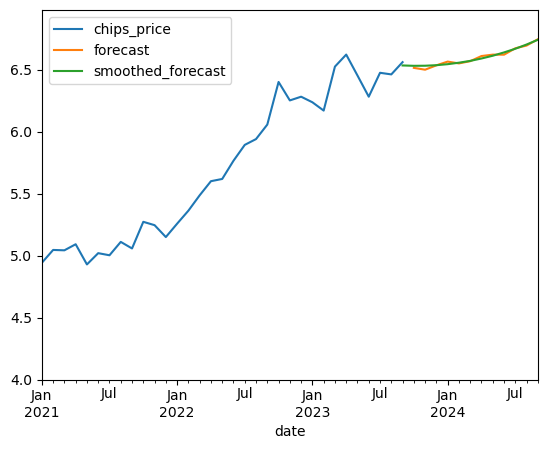

In [7]:
# Plot original series and predictions
ax = data["chips_price"].plot()
ax = forecast.plot(ax=ax)
ax = smoothed_forecast.plot(ax=ax)
_ = ax.legend()
_ = ax.set_xlim(xmin="2021")
_ = ax.set_ylim(ymin=4)